In [ ]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python --upgrade


Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86


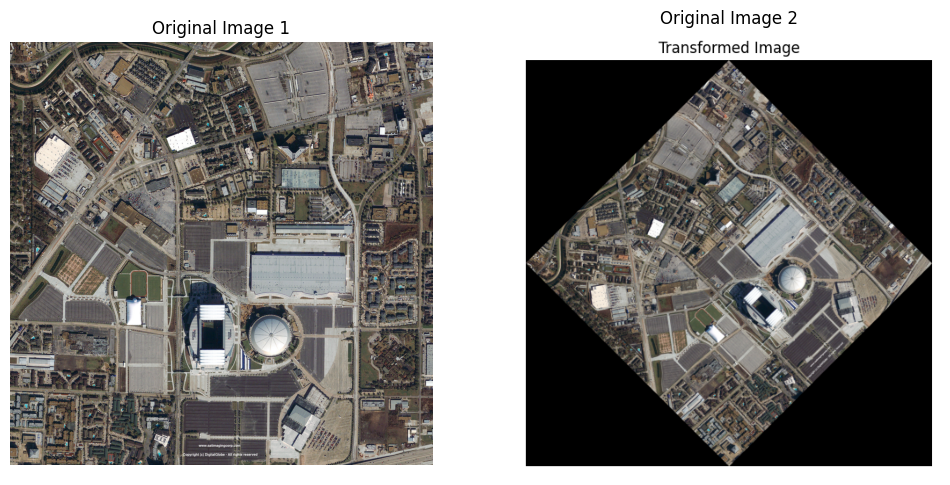

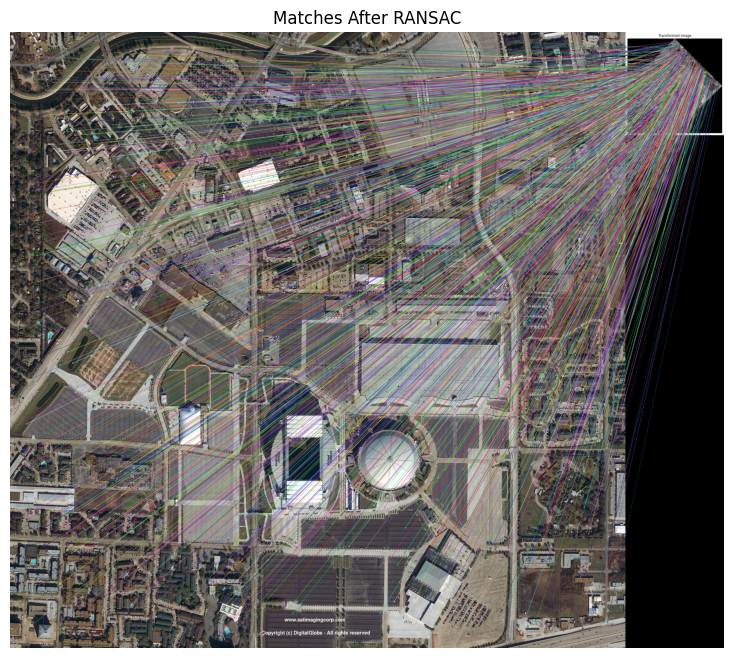

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
img1 = cv2.imread('building.jpg')   # Replace with correct filename
img2 = cv2.imread('build1.png')

# Check if images are loaded
if img1 is None or img2 is None:
    raise FileNotFoundError("Make sure 'house.jpg' and 'house1.png' are uploaded to the Colab session.")

# ✅ Show original images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Original Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Original Image 2")
plt.axis('off')

plt.show()

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Use SIFT for keypoint detection
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Match descriptors using FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# RANSAC for homography
if len(good_matches) >= 4:
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matches_mask = mask.ravel().tolist()

    # Draw inlier matches only
    ransac_result = cv2.drawMatches(
        img1, kp1, img2, kp2, good_matches, None,
        matchesMask=matches_mask,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # ✅ Show result after RANSAC
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(ransac_result, cv2.COLOR_BGR2RGB))
    plt.title("Matches After RANSAC")
    plt.axis('off')
    plt.show()
else:
    print("Not enough matches to apply RANSAC.")
